# Programming Exercise 8B:
# Recommender Systems


## Introduction 

In this exercise you will
use collaborative filtering to build a recommender system for movies. 

Before we begin with the exercises, we need to import all libraries required for this programming exercise. We will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, [`matplotlib`](https://matplotlib.org/) for plotting, and [`scipy`](https://docs.scipy.org/doc/scipy/reference/) for scientific and numerical computation functions and tools. 

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot
import matplotlib as mpl

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions and others
import utils


# tells matplotlib to embed plots within the notebook
%matplotlib inline

##  Recommender Systems

In this  exrcise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings ([MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/) from GroupLens Research). This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies. 

In the next parts of this exercise, you will implement the function `cofiCostFunc` that computes the collaborative filtering objective function and gradient. After implementing the cost function and gradient, you will use `scipy.optimize.minimize` to learn the parameters for collaborative filtering.

### 2.1 Movie ratings dataset

The next cell will load the dataset `ex8_movies.mat`, providing the variables `Y` and `R`.
The matrix `Y` (a `num_movies` $\times$ `num_users` matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix `R` is an binary-valued indicator matrix, where $R(i, j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i, j) = 0$ otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R(i, j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.

To help you understand the matrix `Y`, the following cell will compute the average movie rating for the first movie (Toy Story) and print its average rating.

Average rating for movie 1 (Toy Story): 3.878319 / 5


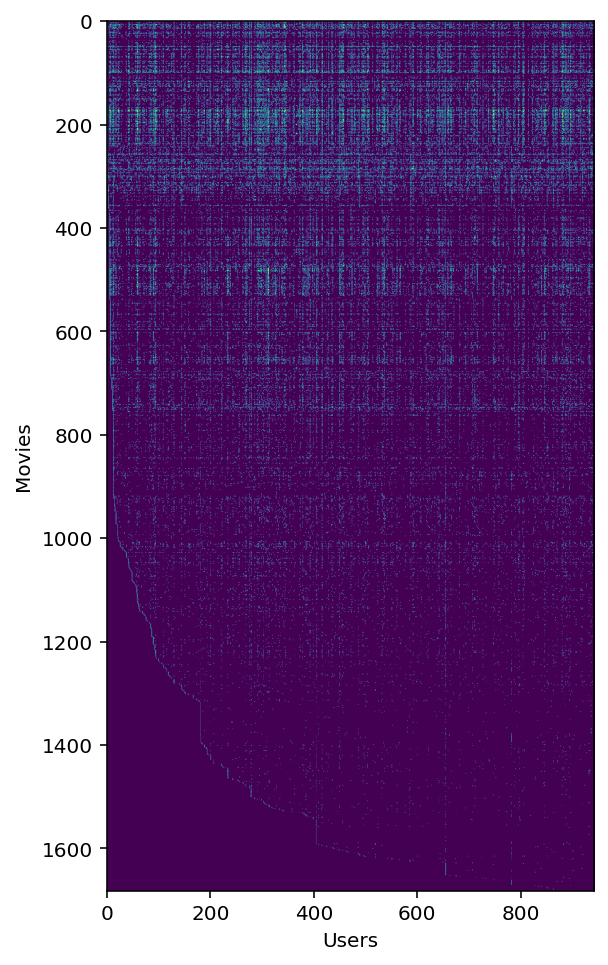

In [2]:
# Load data
data = loadmat(os.path.join('Data', 'ex8_movies.mat'))
Y, R = data['Y'], data['R']

# Y is a 1682x943 matrix, containing ratings (1-5) of 
# 1682 movies on 943 users

# R is a 1682x943 matrix, where R(i,j) = 1 
# if and only if user j gave a rating to movie i

# From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): %f / 5' %
      np.mean(Y[0, R[0, :] == 1]))

# We can "visualize" the ratings matrix by plotting it with imshow
pyplot.figure(figsize=(8, 8))
pyplot.imshow(Y)
pyplot.ylabel('Movies')
pyplot.xlabel('Users')
pyplot.grid(False)

Throughout this part of the exercise, you will also be working with the matrices, `X` and `Theta`:

$$ \text{X} = 
\begin{bmatrix}
- \left(x^{(1)}\right)^T - \\
- \left(x^{(2)}\right)^T - \\
\vdots \\
- \left(x^{(n_m)}\right)^T - \\
\end{bmatrix}, \quad
\text{Theta} = 
\begin{bmatrix}
- \left(\theta^{(1)}\right)^T - \\
- \left(\theta^{(2)}\right)^T - \\
\vdots \\
- \left(\theta^{(n_u)}\right)^T - \\
\end{bmatrix}.
$$

The $i^{th}$ row of `X` corresponds to the feature vector $x^{(i)}$ for the $i^{th}$ movie, and the $j^{th}$ row of `Theta` corresponds to one parameter vector $\theta^{(j)}$, for the $j^{th}$ user. Both $x^{(i)}$ and $\theta^{(j)}$ are n-dimensional vectors. For the purposes of this exercise, you will use $n = 100$, and therefore, $x^{(i)} \in \mathbb{R}^{100}$ and $\theta^{(j)} \in \mathbb{R}^{100}$. Correspondingly, `X` is a $n_m \times 100$ matrix and `Theta` is a $n_u \times 100$ matrix.

<a id="section3"></a>
### 2.2 Collaborative filtering learning algorithm

Now, you will start implementing the collaborative filtering learning algorithm. You will start by implementing the cost function (without regularization).

The collaborative filtering algorithm in the setting of movie recommendations considers a set of n-dimensional parameter vectors $x^{(1)}, \dots, x^{(n_m)}$ and $\theta^{(1)} , \dots, \theta^{(n_u)}$, where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)} = \left( \theta^{(j)} \right)^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors $x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}$ that produce the best fit (minimizes the squared error).

You will complete the code in `cofiCostFunc` to compute the cost function and gradient for collaborative filtering. Note that the parameters to the function (i.e., the values that you are trying to learn) are `X` and `Theta`. In order to use an off-the-shelf minimizer such as `scipy`'s `minimize` function, the cost function has been set up to unroll the parameters into a single vector called `params`. You had previously used the same vector unrolling method in the neural networks programming exercise.

#### 2.2.1 Collaborative filtering cost function

The collaborative filtering cost function (without regularization) is given by

$$
J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots,\theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)^2
$$

You should now modify the function `cofiCostFunc` to return this cost in the variable `J`. Note that you should be accumulating the cost for user $j$ and movie $i$ only if `R[i,j] = 1`.

<div class="alert alert-block alert-warning">
**Implementation Note**: We strongly encourage you to use a vectorized implementation to compute $J$, since it will later by called many times by `scipy`'s optimization package. As usual, it might be easiest to first write a non-vectorized implementation (to make sure you have the right answer), and the modify it to become a vectorized implementation (checking that the vectorization steps do not change your algorithm’s output). To come up with a vectorized implementation, the following tip might be helpful: You can use the $R$ matrix to set selected entries to 0. For example, `R * M` will do an element-wise multiplication between `M`
and `R`; since `R` only has elements with values either 0 or 1, this has the effect of setting the elements of M to 0 only when the corresponding value in R is 0. Hence, `np.sum( R * M)` is the sum of all the elements of `M` for which the corresponding element in `R` equals 1.
</div>

<a id="cofiCostFunc"></a>

In [3]:
def cofiCostFunc(params, Y, R, num_users, num_movies,
                      num_features, lambda_=0.0):
    """
    Collaborative filtering cost function.
    
    Parameters
    ----------
    params : array_like
        The parameters which will be optimized. This is a one
        dimensional vector of shape (num_movies x num_users, 1). It is the 
        concatenation of the feature vectors X and parameters Theta.
    
    Y : array_like
        A matrix of shape (num_movies x num_users) of user ratings of movies.
    
    R : array_like
        A (num_movies x num_users) matrix, where R[i, j] = 1 if the 
        i-th movie was rated by the j-th user.
    
    num_users : int
        Total number of users.
    
    num_movies : int
        Total number of movies.
    
    num_features : int
        Number of features to learn.
    
    lambda_ : float, optional
        The regularization coefficient.
    
    Returns
    -------
    J : float
        The value of the cost function at the given params.
    
    grad : array_like
        The gradient vector of the cost function at the given params.
        grad has a shape (num_movies x num_users, 1)
    
    Instructions
    ------------
    Compute the cost function and gradient for collaborative filtering.
    Concretely, you should first implement the cost function (without
    regularization) and make sure it is matches our costs. After that,
    you should implement thegradient and use the checkCostFunction routine 
    to check that the gradient is correct. Finally, you should implement
    regularization.
    
    Notes
    -----
    - The input params will be unraveled into the two matrices:
        X : (num_movies  x num_features) matrix of movie features
        Theta : (num_users  x num_features) matrix of user features

    - You should set the following variables correctly:

        X_grad : (num_movies x num_features) matrix, containing the 
                 partial derivatives w.r.t. to each element of X
        Theta_grad : (num_users x num_features) matrix, containing the 
                     partial derivatives w.r.t. to each element of Theta

    - The returned gradient will be the concatenation of the raveled 
      gradients X_grad and Theta_grad.
    """
    # Unfold the U and W matrices from params
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)

    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # ====================== YOUR CODE HERE ======================
    
    J = (1 / 2) * np.sum(np.square((X.dot(Theta.T) - Y) * R)) + (lambda_ / 2) * np.sum(np.square(X)) + \
                                                                (lambda_ / 2) * np.sum(np.square(Theta))
    
    for i in range(R.shape[0]):
        
        idx = np.where(R[i, :] == 1)[0]
        Theta_temp = Theta[idx, :]
        Y_temp = Y[i, idx]
        X_grad[i, :] = np.dot(np.dot(X[i, :], Theta_temp.T) - Y_temp, Theta_temp) + lambda_ * X[i, :]
        
    for j in range(R.shape[1]):
        
        idx = np.where(R[:, j] == 1)[0]
        X_temp = X[idx, :]
        Y_temp = Y[idx, j]
        Theta_grad[j, :] = np.dot(np.dot(X_temp, Theta[j, :]) - Y_temp, X_temp) + lambda_ * Theta[j, :]

    
    # =============================================================
    
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    return J, grad

After you have completed the function, the next cell will run your cost function. To help you debug your cost function, we have included set of weights that we trained on that.  You should expect to see an output of 22.22.

In [4]:
#  Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
data = loadmat(os.path.join('Data', 'ex8_movieParams.mat'))
X, Theta, num_users, num_movies, num_features = data['X'],\
        data['Theta'], data['num_users'], data['num_movies'], data['num_features']

#  Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3

X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, 0:num_users]
R = R[:num_movies, 0:num_users]

#  Evaluate cost function
J, _ = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]),
                    Y, R, num_users, num_movies, num_features)
           
print('Cost at loaded parameters:  %.2f \n(this value should be about 22.22)' % J)

Cost at loaded parameters:  22.22 
(this value should be about 22.22)


<a id="section4"></a>
#### 2.2.2 Collaborative filtering gradient

Now you should implement the gradient (without regularization). Specifically, you should complete the code in `cofiCostFunc` to return the variables `X_grad` and `Theta_grad`. Note that `X_grad` should be a matrix of the same size as `X` and similarly, `Theta_grad` is a matrix of the same size as
`Theta`. The gradients of the cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} $$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} $$

Note that the function returns the gradient for both sets of variables by unrolling them into a single vector. After you have completed the code to compute the gradients, the next cell run a gradient check
(available in `utils.checkCostFunction`) to numerically check the implementation of your gradients (this is similar to the numerical check that you used in the neural networks exercise. If your implementation is correct, you should find that the analytical and numerical gradients match up closely.

<div class="alert alert-block alert-warning">
**Implementation Note:** You can get full credit for this assignment without using a vectorized implementation, but your code will run much more slowly (a small number of hours), and so we recommend that you try to vectorize your implementation. To get started, you can implement the gradient with a for-loop over movies
(for computing $\frac{\partial J}{\partial x^{(i)}_k}$) and a for-loop over users (for computing $\frac{\partial J}{\theta_k^{(j)}}$). When you first implement the gradient, you might start with an unvectorized version, by implementing another inner for-loop that computes each element in the summation. After you have completed the gradient computation this way, you should try to vectorize your implementation (vectorize the inner for-loops), so that you are left with only two for-loops (one for looping over movies to compute $\frac{\partial J}{\partial x_k^{(i)}}$ for each movie, and one for looping over users to compute $\frac{\partial J}{\partial \theta_k^{(j)}}$ for each user).
</div>

<div class="alert alert-block alert-warning">
**Implementation Tip:** To perform the vectorization, you might find this helpful: You should come up with a way to compute all the derivatives associated with $x_1^{(i)} , x_2^{(i)}, \dots , x_n^{(i)}$ (i.e., the derivative terms associated with the feature vector $x^{(i)}$) at the same time. Let us define the derivatives for the feature vector of the $i^{th}$ movie as:

$$ \left(X_{\text{grad}} \left(i, :\right)\right)^T = 
\begin{bmatrix}
\frac{\partial J}{\partial x_1^{(i)}} \\
\frac{\partial J}{\partial x_2^{(i)}} \\
\vdots \\
\frac{\partial J}{\partial x_n^{(i)}}
\end{bmatrix} = \quad
\sum_{j:r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right) \theta^{(j)}
$$

To vectorize the above expression, you can start by indexing into `Theta` and `Y` to select only the elements of interests (that is, those with `r[i, j] = 1`). Intuitively, when you consider the features for the $i^{th}$ movie, you only need to be concerned about the users who had given ratings to the movie, and this allows you to remove all the other users from `Theta` and `Y`. <br/><br/>


Concretely, you can set `idx = np.where(R[i, :] == 1)[0]` to be a list of all the users that have rated movie $i$. This will allow you to create the temporary matrices `Theta_temp = Theta[idx, :]` and `Y_temp = Y[i, idx]` that index into `Theta` and `Y` to give you only the set of users which have rated the $i^{th}$ movie. This will allow you to write the derivatives as: <br>

`X_grad[i, :] = np.dot(np.dot(X[i, :], Theta_temp.T) - Y_temp, Theta_temp)`

<br><br>
Note that the vectorized computation above returns a row-vector instead. After you have vectorized the computations of the derivatives with respect to $x^{(i)}$, you should use a similar method to vectorize the derivatives with respect to $θ^{(j)}$ as well.
</div>

[Click here to go back to the function `cofiCostFunc` to update it](#cofiCostFunc). 

<font color="red"> Do not forget to re-execute the cell containg the function `cofiCostFunc` so that it is updated with your implementation of the gradient computation.</font>

In [5]:
#  Check gradients by running checkcostFunction
utils.checkCostFunction(cofiCostFunc)

[[-0.26505099 -0.26505099]
 [-0.65551572 -0.65551572]
 [ 0.4760719   0.4760719 ]
 [ 0.90630183  0.90630183]
 [ 6.86213782  6.86213782]
 [ 0.39271382  0.39271382]
 [ 0.41387038  0.41387038]
 [ 5.34862483  5.34862483]
 [-0.3059252  -0.3059252 ]
 [ 0.02075578  0.02075578]
 [-0.79630118 -0.79630118]
 [ 0.55710739  0.55710739]
 [ 1.77242616  1.77242616]
 [-5.52979829 -5.52979829]
 [ 1.09285438  1.09285438]
 [-1.79753793 -1.79753793]
 [ 2.88215959  2.88215959]
 [-1.62850166 -1.62850166]
 [ 0.88986015  0.88986015]
 [-2.52722108 -2.52722108]
 [ 0.41231841  0.41231841]
 [-0.35577347 -0.35577347]
 [ 0.32033201  0.32033201]
 [-0.57252403 -0.57252403]
 [-0.49349385 -0.49349385]
 [ 1.20451793  1.20451793]
 [ 1.46625079  1.46625079]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your cost function implementation is correct, then the relative difference will be small (less than 1e-9).

Relative Difference: 8.73832e-13


<a id="section5"></a>
#### 2.2.3 Regularized cost function

The cost function for collaborative filtering with regularization is given by

$$ J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right)^2 + \left( \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^{n} \left( \theta_k^{(j)} \right)^2  \right) + \left( \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \left(x_k^{(i)} \right)^2 \right) $$

You should now add regularization to your original computations of the cost function, $J$. After you are done, the next cell will run your regularized cost function, and you should expect to see a cost of about 31.34.

[Click here to go back to the function `cofiCostFunc` to update it](#cofiCostFunc)
<font color="red"> Do not forget to re-execute the cell containing the function `cofiCostFunc` so that it is updated with your implementation of regularized cost function.</font>

In [6]:
#  Evaluate cost function
J, _ = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]),
                    Y, R, num_users, num_movies, num_features, 1.5)
           
print('Cost at loaded parameters (lambda = 1.5): %.2f' % J)
print('              (this value should be about 31.34)')

Cost at loaded parameters (lambda = 1.5): 31.34
              (this value should be about 31.34)


<a id="section6"></a>
#### 2.2.4 Regularized gradient

Now that you have implemented the regularized cost function, you should proceed to implement regularization for the gradient. You should add to your implementation in `cofiCostFunc` to return the regularized gradient
by adding the contributions from the regularization terms. Note that the gradients for the regularized cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} + \lambda x_k^{(i)} $$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} + \lambda \theta_k^{(j)} $$

This means that you just need to add $\lambda x^{(i)}$ to the `X_grad[i,:]` variable described earlier, and add $\lambda \theta^{(j)}$ to the `Theta_grad[j, :]` variable described earlier.

[Click here to go back to the function `cofiCostFunc` to update it](#cofiCostFunc)
<font color="red"> Do not forget to re-execute the cell containing the function `cofiCostFunc` so that it is updated with your implementation of the gradient for the regularized cost function.</font>

After you have completed the code to compute the gradients, the following cell will run another gradient check (`utils.checkCostFunction`) to numerically check the implementation of your gradients.

In [7]:
#  Check gradients by running checkCostFunction
utils.checkCostFunction(cofiCostFunc, 1.5)

[[ -2.92211179  -2.92211179]
 [ 13.56622762  13.56622762]
 [ -2.4961922   -2.4961922 ]
 [  6.08497086   6.08497086]
 [ -3.78041179  -3.78041179]
 [  4.65477296   4.65477296]
 [  5.3375046    5.3375046 ]
 [-12.64746991 -12.64746991]
 [  1.55519817   1.55519817]
 [ -0.43544078  -0.43544078]
 [  0.49735725   0.49735725]
 [  1.16357798   1.16357798]
 [  1.34871848   1.34871848]
 [ -6.79361232  -6.79361232]
 [  1.21901793   1.21901793]
 [  4.90839506   4.90839506]
 [ -9.60978064  -9.60978064]
 [  3.70467809   3.70467809]
 [ -8.1523664   -8.1523664 ]
 [  3.04352431   3.04352431]
 [ -6.42769932  -6.42769932]
 [ -1.66298208  -1.66298208]
 [  3.06435058   3.06435058]
 [  0.97381244   0.97381244]
 [  0.01485321   0.01485321]
 [-10.24965426 -10.24965426]
 [  2.38557136   2.38557136]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your cost function implementation is correct, then the relative difference will be small (less than 1

### 2.3 Learning movie recommendations 

After you have finished implementing the collaborative filtering cost function and gradient, you can now start training your algorithm to make movie recommendations for yourself. In the next cell, you can enter your own movie preferences, so that later when the algorithm runs, you can get your own movie recommendations! We have filled out some values according to our own preferences, but you should change this according to your own tastes. The list of all movies and their number in the dataset can be found listed in the file `Data/movie_idx.txt`.

In [8]:
#  Before we will train the collaborative filtering model, we will first
#  add ratings that correspond to a new user that we just observed. This
#  part of the code will also allow you to put in your own ratings for the
#  movies in our dataset!
movieList = utils.loadMovieList()
n_m = len(movieList)

#  Initialize my ratings
my_ratings = np.zeros(n_m)

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
# Note that the index here is ID-1, since we start index from 0.
my_ratings[0] = 4

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('New user ratings:')
print('-----------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d stars: %s' % (my_ratings[i], movieList[i]))

New user ratings:
-----------------
Rated 4 stars: Toy Story (1995)
Rated 3 stars: Twelve Monkeys (1995)
Rated 5 stars: Usual Suspects, The (1995)
Rated 4 stars: Outbreak (1995)
Rated 5 stars: Shawshank Redemption, The (1994)
Rated 3 stars: While You Were Sleeping (1995)
Rated 5 stars: Forrest Gump (1994)
Rated 2 stars: Silence of the Lambs, The (1991)
Rated 4 stars: Alien (1979)
Rated 5 stars: Die Hard 2 (1990)
Rated 5 stars: Sphere (1998)


#### 2.3.1 Recommendations

After the additional ratings have been added to the dataset, the script
will proceed to train the collaborative filtering model. This will learn the
parameters X and Theta. To predict the rating of movie i for user j, you need to compute (θ (j) ) T x (i) . The next part of the script computes the ratings for
all the movies and users and displays the movies that it recommends (Figure
4), according to ratings that were entered earlier in the script. Note that
you might obtain a different set of the predictions due to different random
initializations.

In [9]:
#  Now, you will train the collaborative filtering model on a movie rating 
#  dataset of 1682 movies and 943 users

#  Load data
data = loadmat(os.path.join('Data', 'ex8_movies.mat'))
Y, R = data['Y'], data['R']

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
#  943 users

#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  Add our own ratings to the data matrix
Y = np.hstack([my_ratings[:, None], Y])
R = np.hstack([(my_ratings > 0)[:, None], R])

#  Normalize Ratings
Ynorm, Ymean = utils.normalizeRatings(Y, R)

#  Useful Values
num_movies, num_users = Y.shape
num_features = 10

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

# Set options for scipy.optimize.minimize
options = {'maxiter': 100}

# Set Regularization
lambda_ = 10
res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                               num_movies, num_features, lambda_),
                        initial_parameters,
                        method='TNC',
                        jac=True,
                        options=options)
theta = res.x

# Unfold the returned theta back into U and W
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

print('Recommender system learning completed.')

After training the model, you can now make recommendations by computing the predictions matrix.

In [0]:
p = np.dot(X, Theta.T)
my_predictions = p[:, 0] + Ymean

movieList = utils.loadMovieList()

ix = np.argsort(my_predictions)[::-1]

print('Top recommendations for you:')
print('----------------------------')
for i in range(10):
    j = ix[i]
    print('Predicting rating %.1f for movie %s' % (my_predictions[j], movieList[j]))

print('\nOriginal ratings provided:')
print('--------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' % (my_ratings[i], movieList[i]))